## AI plan

### 1. Entry zone analyse

In [1]:
# def classify_entry_zone(x, y):
#     """
#     Classificeer final third entry in zone
    
#     Parameters:
#     - x, y: coördinaten van entry
    
#     Returns:
#     - zone name: 'left', 'center', 'right'
#     """
#     # Final third begint bij x = 17.5
#     if x < 17.5:
#         return None  # Nog geen final third
    
#     # Horizontaal: links/centrum/rechts
#     if y < -12:
#         return 'left'
#     elif y > 12:
#         return 'right'
#     else:
#         return 'center'

# def analyze_entry_zones(events_df, team_id):
#     """
#     Analyseer final third entries per zone
    
#     Parameters:
#     - events_df: DataFrame met events
#     - team_id: welk team (Belgium)
    
#     Returns:
#     - DataFrame met entries per zone + outcomes
#     """
    
#     # Filter op final third entries (afhankelijk van je event types)
#     # Dit kan zijn: carries into final third, passes into final third, etc.
    
#     # Optie 1: Als je expliciet "final third entry" events hebt
#     entries = events_df[
#         (events_df['team_id'] == team_id) &
#         (events_df['event_type'].isin(['carry', 'pass'])) &
#         (events_df['end_x'] >= 17.5) &  # eindigt in final third
#         (events_df['x'] < 17.5)  # begint ervoor
#     ].copy()
    
#     # Optie 2: Als je dit moet afleiden uit passes/carries
#     # entries = find_entries_from_actions(events_df, team_id)
    
#     # Classificeer zone
#     entries['entry_zone'] = entries.apply(
#         lambda row: classify_entry_zone(row['end_x'], row['end_y']), 
#         axis=1
#     )
    
#     # Analyseer wat er na entry gebeurde
#     entries['outcome'] = entries.apply(
#         lambda row: analyze_sequence_outcome(events_df, row.name), 
#         axis=1
#     )
    
#     return entries

# def analyze_sequence_outcome(events_df, entry_idx, lookforward=10):
#     """
#     Bepaal wat er gebeurde na een final third entry
    
#     Parameters:
#     - events_df: alle events
#     - entry_idx: index van entry event
#     - lookforward: hoeveel events vooruit kijken
    
#     Returns:
#     - dict met outcome info
#     """
    
#     # Kijk naar volgende X events van hetzelfde team
#     entry_event = events_df.loc[entry_idx]
#     team_id = entry_event['team_id']
#     timestamp = entry_event['timestamp']
    
#     # Volgende events binnen 15 seconden van hetzelfde team
#     next_events = events_df[
#         (events_df.index > entry_idx) &
#         (events_df['timestamp'] <= timestamp + 15) &
#         (events_df['team_id'] == team_id)
#     ].head(lookforward)
    
#     outcome = {
#         'shot': False,
#         'goal': False,
#         'xG': 0,
#         'turnover': False,
#         'foul_won': False,
#         'corner': False,
#         'end_reason': 'unknown'
#     }
    
#     for _, event in next_events.iterrows():
#         if event['event_type'] == 'shot':
#             outcome['shot'] = True
#             outcome['xG'] = event.get('xG', 0)
#             if event.get('outcome') == 'goal':
#                 outcome['goal'] = True
#             outcome['end_reason'] = 'shot'
#             break
#         elif event['event_type'] in ['interception', 'tackle']:
#             outcome['turnover'] = True
#             outcome['end_reason'] = 'turnover'
#             break
#         elif event['event_type'] == 'foul':
#             outcome['foul_won'] = True
#             outcome['end_reason'] = 'foul_won'
#             break
    
#     # Check of er een event van andere team is (= balverlies)
#     opponent_event = events_df[
#         (events_df.index > entry_idx) &
#         (events_df['timestamp'] <= timestamp + 15) &
#         (events_df['team_id'] != team_id)
#     ].head(1)
    
#     if len(opponent_event) > 0 and not outcome['shot']:
#         outcome['turnover'] = True
#         outcome['end_reason'] = 'lost_possession'
    
#     return outcome

# def summarize_entries_by_zone(entries_df):
#     """
#     Maak samenvatting per zone
#     """
    
#     summary = entries_df.groupby('entry_zone').agg({
#         'event_id': 'count',  # aantal entries
#         'outcome': lambda x: sum([o['shot'] for o in x]),  # aantal shots
#     }).rename(columns={'event_id': 'entries', 'outcome': 'shots'})
    
#     # xG per zone
#     summary['total_xG'] = entries_df.groupby('entry_zone')['outcome'].apply(
#         lambda x: sum([o['xG'] for o in x])
#     )
    
#     summary['xG_per_entry'] = summary['total_xG'] / summary['entries']
#     summary['shot_rate'] = summary['shots'] / summary['entries']
    
#     # Turnovers
#     summary['turnovers'] = entries_df.groupby('entry_zone')['outcome'].apply(
#         lambda x: sum([o['turnover'] for o in x])
#     )
#     summary['turnover_rate'] = summary['turnovers'] / summary['entries']
    
#     return summary

### 2. Passes in behind

In [2]:
# def detect_passes_in_behind(events_df, tracking_df, team_id):
#     """
#     Detecteer passes die achter de laatste verdedigingslinie gaan
    
#     Parameters:
#     - events_df: event data
#     - tracking_df: tracking data (long format)
#     - team_id: aanvallend team
    
#     Returns:
#     - DataFrame met in-behind passes
#     """
    
#     # Filter passes van aanvallend team
#     passes = events_df[
#         (events_df['team_id'] == team_id) &
#         (events_df['event_type'] == 'pass')
#     ].copy()
    
#     in_behind_passes = []
    
#     for idx, pass_event in passes.iterrows():
#         # Vind frame rond dit event
#         timestamp = pass_event['timestamp']
#         frame = tracking_df[
#             (tracking_df['timestamp'] >= timestamp - 0.1) &
#             (tracking_df['timestamp'] <= timestamp + 0.1)
#         ]['frame_id'].iloc[0] if len(tracking_df[
#             (tracking_df['timestamp'] >= timestamp - 0.1) &
#             (tracking_df['timestamp'] <= timestamp + 0.1)
#         ]) > 0 else None
        
#         if frame is None:
#             continue
        
#         # Bepaal defending team
#         defending_team = 'away' if team_id == 'home' else 'home'
        
#         # Haal verdedigers op
#         defenders = tracking_df[
#             (tracking_df['frame_id'] == frame) &
#             (tracking_df['team_id'] == defending_team)
#         ]
        
#         if len(defenders) == 0:
#             continue
        
#         # Laatste verdedigingslinie (hoogste x van verdedigers)
#         defensive_line = defenders['x'].max()
        
#         # Check of pass erachter gaat
#         pass_end_x = pass_event['end_x']
        
#         if pass_end_x > defensive_line:
#             # Dit is een pass in-behind!
#             in_behind_passes.append({
#                 'event_id': pass_event['event_id'],
#                 'timestamp': timestamp,
#                 'x': pass_event['x'],
#                 'y': pass_event['y'],
#                 'end_x': pass_end_x,
#                 'end_y': pass_event['end_y'],
#                 'defensive_line': defensive_line,
#                 'meters_behind': pass_end_x - defensive_line,
#                 'outcome': pass_event.get('outcome', 'unknown'),
#                 'zone': classify_zone_simple(pass_event['x'], pass_event['y'])
#             })
    
#     return pd.DataFrame(in_behind_passes)

# def classify_zone_simple(x, y):
#     """Simpele zone classificatie"""
#     if x < -17.5:
#         return 'own_third'
#     elif x < 17.5:
#         return 'middle_third'
#     else:
#         return 'final_third'

# def analyze_in_behind_opportunities(tracking_df, events_df, team_id):
#     """
#     Analyseer hoeveel kansen er waren voor in-behind passes
    
#     Returns:
#     - Momenten waar defensive line hoog stond
#     - Ruimte achter aanwezig
#     - Werd het benut?
#     """
    
#     defending_team = 'away' if team_id == 'home' else 'home'
    
#     # Sample frames tijdens balbezit
#     possession_frames = tracking_df[
#         tracking_df['last_touch'] == team_id
#     ]['frame_id'].unique()[::25]  # elke seconde
    
#     opportunities = []
    
#     for frame in possession_frames:
#         frame_data = tracking_df[tracking_df['frame_id'] == frame]
        
#         defenders = frame_data[frame_data['team_id'] == defending_team]
        
#         if len(defenders) == 0:
#             continue
        
#         defensive_line = defenders['x'].max()
        
#         # Is de linie "hoog" (> 20m)?
#         if defensive_line > 20:
#             # Ruimte achter de linie
#             space_behind = 52.5 - defensive_line
            
#             # Was er een pass in-behind geprobeerd?
#             timestamp = frame_data['timestamp'].iloc[0]
#             pass_attempted = len(events_df[
#                 (events_df['team_id'] == team_id) &
#                 (events_df['event_type'] == 'pass') &
#                 (events_df['timestamp'] >= timestamp - 0.5) &
#                 (events_df['timestamp'] <= timestamp + 0.5) &
#                 (events_df['end_x'] > defensive_line)
#             ]) > 0
            
#             opportunities.append({
#                 'frame_id': frame,
#                 'timestamp': timestamp,
#                 'defensive_line': defensive_line,
#                 'space_behind': space_behind,
#                 'pass_attempted': pass_attempted
#             })
    
#     return pd.DataFrame(opportunities)

### 3. Flankwissel analyse

In [3]:
# def detect_switches_of_play(events_df, team_id, min_distance=30):
#     """
#     Detecteer flankwissels (simpele versie)
    
#     Parameters:
#     - events_df: event data
#     - team_id: aanvallend team
#     - min_distance: minimale horizontale afstand (y) voor switch
    
#     Returns:
#     - DataFrame met switches
#     """
    
#     # Filter passes van team
#     passes = events_df[
#         (events_df['team_id'] == team_id) &
#         (events_df['event_type'] == 'pass') &
#         (events_df['outcome'] == 'complete')  # alleen succesvolle passes
#     ].copy()
    
#     switches = []
    
#     for idx, pass_event in passes.iterrows():
#         # Horizontale afstand
#         y_distance = abs(pass_event['end_y'] - pass_event['y'])
        
#         # Is dit een switch? (grote horizontale beweging)
#         if y_distance >= min_distance:
            
#             # Zoek vorige passes om touches te tellen
#             prev_passes = events_df[
#                 (events_df.index < idx) &
#                 (events_df['team_id'] == team_id) &
#                 (events_df['event_type'] == 'pass') &
#                 (events_df['timestamp'] >= pass_event['timestamp'] - 10)
#             ]
            
#             # Tel touches sinds bal op andere kant was
#             touches_to_switch = len(prev_passes[
#                 (prev_passes['y'] * pass_event['y'] < 0)  # andere kant
#             ])
            
#             # Analyseer outcome
#             outcome = analyze_sequence_outcome(events_df, idx, lookforward=5)
            
#             switches.append({
#                 'event_id': pass_event['event_id'],
#                 'timestamp': pass_event['timestamp'],
#                 'from_side': 'left' if pass_event['y'] < -12 else 'right',
#                 'to_side': 'left' if pass_event['end_y'] < -12 else 'right',
#                 'y_distance': y_distance,
#                 'touches_before': touches_to_switch,
#                 'x_position': pass_event['x'],  # waar op veld
#                 'zone': classify_zone_simple(pass_event['x'], pass_event['y']),
#                 'outcome': outcome
#             })
    
#     return pd.DataFrame(switches)

# def analyze_switch_effectiveness(switches_df):
#     """
#     Analyseer effectiviteit van switches
#     """
    
#     summary = {
#         'total_switches': len(switches_df),
#         'avg_touches': switches_df['touches_before'].mean(),
#         'by_touches': switches_df.groupby(
#             pd.cut(switches_df['touches_before'], bins=[0, 2, 4, 100], labels=['1-2', '3-4', '5+'])
#         ).agg({
#             'event_id': 'count',
#             'outcome': lambda x: sum([o['shot'] for o in x]) / len(x)  # shot rate
#         }).rename(columns={'event_id': 'switches', 'outcome': 'shot_rate'}),
#         'by_zone': switches_df.groupby('zone').size()
#     }
    
#     return summary

# Imports

In [4]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from config import setup_logging
from extract import MatchDataLoader
from transform import transform_tracking_to_long_format, get_possession_frames, analyze_block_by_ball_position

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Reload modules when code is changed (uncomment for development)
%load_ext autoreload
%autoreload 2

# Init logging
logger = setup_logging(log_file="../logs/dominance_analysis.log")

# 1. Load data

In [5]:
# Initialize data loader
loader = MatchDataLoader()

# Load all data
events_data, player_data, tracking_data, mapping_data = loader.load_all_data()

2025-11-11 17:35:40,321 - extract.data_loading - INFO - ✓ Loaded 1710 events from ../data/20251010-Belgium-North-Macedonia/events.json
2025-11-11 17:35:40,322 - extract.data_loading - INFO - ✓ Loaded 32 players from ../data/20251010-Belgium-North-Macedonia/events.json
2025-11-11 17:35:41,026 - extract.data_loading - INFO - ✓ Loaded 145567 tracking entries from ../data/20251010-Belgium-North-Macedonia/tracking.pkl
2025-11-11 17:35:41,027 - extract.data_loading - INFO - ✓ Loaded mapping data from ../data/20251010-Belgium-North-Macedonia/mapping.json


## 2. Entry zone analyse

In [6]:
events_data.head()

,eventId,playerId,timestamp,playerName,groupId,groupName,teamId,teamName,receiverId,receiverName,receiverTeamId,receiverTeamName,baseTypeId,baseTypeName,subTypeId,subTypeName,resultId,resultName,bodyPartId,bodyPartName,shotTypeId,shotTypeName,foulTypeId,foulTypeName,positionTypeId,positionTypeName,formationTypeId,formationTypeName,partId,partName,startTimeMs,endTimeMs,startPosXM,startPosYM,endPosXM,endPosYM,sequenceId,sequenceEvent,possessionTypeId,possessionTypeName,sequenceStart,sequenceEnd,metrics,labels,descriptives,synced
0,0,-1,1760121900000,NOT_APPLICABLE,1,HOME,2,Belgium,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,17,FORMATION,1700,TEAM_STARTING_FORMATION,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-2,UNKNOWN,1,FIRST_HALF,0,0,0.0,0.0,0.0,0.0,-1,-1,-1,NOT_APPLICABLE,False,False,"{'length': 0.0, 'forwardDisplacement': 0.0, 'l...",[],"{'startZone': '3C', 'endZone': '3C', 'startThi...",False
1,1,-1,1760121900000,NOT_APPLICABLE,2,AWAY,8,North Macedonia,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,17,FORMATION,1700,TEAM_STARTING_FORMATION,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-2,UNKNOWN,1,FIRST_HALF,0,0,0.0,0.0,0.0,0.0,-1,-1,-1,NOT_APPLICABLE,False,False,"{'length': 0.0, 'forwardDisplacement': 0.0, 'l...",[],"{'startZone': '3C', 'endZone': '3C', 'startThi...",False
2,2,95,1760121900000,Thibaut Courtois,1,HOME,2,Belgium,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,18,POSITION,1800,PLAYER_STARTING_POSITION,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,0,GK,-2,UNKNOWN,1,FIRST_HALF,0,0,0.0,0.0,0.0,0.0,-1,-1,-1,NOT_APPLICABLE,False,False,"{'length': 0.0, 'forwardDisplacement': 0.0, 'l...",[],"{'startZone': '3C', 'endZone': '3C', 'startThi...",False
3,3,20,1760121900000,Zeno Koen Debast,1,HOME,2,Belgium,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,18,POSITION,1800,PLAYER_STARTING_POSITION,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,4,CB,-2,UNKNOWN,1,FIRST_HALF,0,0,0.0,0.0,0.0,0.0,-1,-1,-1,NOT_APPLICABLE,False,False,"{'length': 0.0, 'forwardDisplacement': 0.0, 'l...",[],"{'startZone': '3C', 'endZone': '3C', 'startThi...",False
4,4,33,1760121900000,Arthur Nicolas Theate,1,HOME,2,Belgium,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,18,POSITION,1800,PLAYER_STARTING_POSITION,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,-1,NOT_APPLICABLE,4,CB,-2,UNKNOWN,1,FIRST_HALF,0,0,0.0,0.0,0.0,0.0,-1,-1,-1,NOT_APPLICABLE,False,False,"{'length': 0.0, 'forwardDisplacement': 0.0, 'l...",[],"{'startZone': '3C', 'endZone': '3C', 'startThi...",False


In [7]:
events_data[events_data['baseTypeName'] == 'PASS']["resultName"].value_counts()

resultName
SUCCESSFUL      767
UNSUCCESSFUL    163
Name: count, dtype: int64

In [8]:
from transform import get_final_third_entries

final_third_entries = get_final_third_entries(events_data)
final_third_entries.head()

,eventId,timestamp,teamName,baseTypeName,subTypeName,resultName,startPosXM,endPosXM,startPosYM,endPosYM,sequenceId
25,25,1760121905660,Belgium,PASS,PASS,SUCCESSFUL,-19.95,21.00,0.68,-10.88,1
35,35,1760121939613,Belgium,PASS,PASS,SUCCESSFUL,8.40,18.90,14.96,27.20,2
40,40,1760121957420,Belgium,PASS,PASS,SUCCESSFUL,12.60,28.35,19.04,27.20,2
84,84,1760122101650,North Macedonia,PASS,PASS,SUCCESSFUL,14.70,26.25,11.56,23.12,13
96,96,1760122144803,Belgium,PASS,PASS,SUCCESSFUL,9.45,22.05,-13.60,-25.16,15


In [9]:
final_third_entries["teamName"].value_counts()

teamName
Belgium            84
North Macedonia    14
Name: count, dtype: int64

In [10]:
from transform import get_zone_entries_data

entries_df = get_zone_entries_data(final_third_entries, events_data, "Belgium")

In [11]:
entries_df.head()

,eventId,timestamp,teamName,baseTypeName,subTypeName,resultName,startPosXM,endPosXM,startPosYM,endPosYM,sequenceId,entry_zone,outcome,box_entry,box_entry_count,shot,shot_count,goal,goal_count,total_xg,turnover,recycled
25,25,1760121905660,Belgium,PASS,PASS,SUCCESSFUL,-19.95,21.00,0.68,-10.88,1,center,"{'box_entry': False, 'box_entry_count': 0, 'sh...",False,0,False,0,False,0,0.0,False,False
35,35,1760121939613,Belgium,PASS,PASS,SUCCESSFUL,8.40,18.90,14.96,27.20,2,left,"{'box_entry': False, 'box_entry_count': 0, 'sh...",False,0,False,0,False,0,0.0,False,False
40,40,1760121957420,Belgium,PASS,PASS,SUCCESSFUL,12.60,28.35,19.04,27.20,2,left,"{'box_entry': True, 'box_entry_count': 1, 'sho...",True,1,False,0,False,0,0.0,True,False
96,96,1760122144803,Belgium,PASS,PASS,SUCCESSFUL,9.45,22.05,-13.60,-25.16,15,right,"{'box_entry': False, 'box_entry_count': 0, 'sh...",False,0,False,0,False,0,0.0,False,False
113,113,1760122185792,Belgium,PASS,PASS,SUCCESSFUL,9.45,18.90,27.88,27.88,17,left,"{'box_entry': False, 'box_entry_count': 0, 'sh...",False,0,False,0,False,0,0.0,False,False


In [12]:
entries_df["turnover"].value_counts()

turnover
False    66
True     18
Name: count, dtype: int64

In [13]:
from stats import calculate_entry_zone_stats
zone_stats = calculate_entry_zone_stats(entries_df)
zone_stats.head()

,entry_zone,total_entries,entries_with_shot,total_shots,shot_rate,total_xg,xg_per_entry,xg_per_shot,entries_with_box_entry,total_box_entries,box_entry_rate,total_turnovers,turnover_rate,total_recycles,recycle_rate
0,center,15,3,3,0.200000,0.564,0.037600,0.188000,4,4,0.266667,1,0.066667,2,0.133333
1,left,44,6,6,0.136364,1.637,0.037205,0.272833,21,23,0.477273,13,0.295455,5,0.113636
2,right,25,3,3,0.120000,0.144,0.005760,0.048000,9,9,0.360000,4,0.160000,4,0.160000


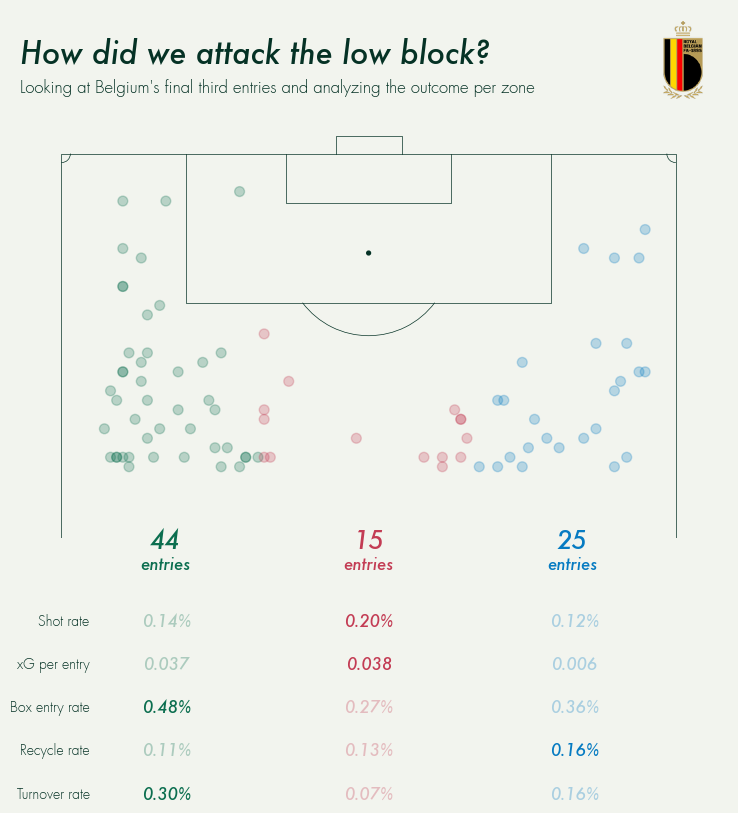

In [116]:
from viz import plot_final_third_entries

fig = plot_final_third_entries(entries_df, zone_stats, "Belgium")
fig.show()